In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Make `conceptlab` importable (in the future we will have this will not be necessary once we've cast this into a package)

In [94]:
import sys
SRC_DIR = '../'
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

Import

In [95]:
import conceptlab as clab
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Initial Example

Generate an example dataset, we specify some arbitrary values for the different covariates

In [96]:
n_tissues = 3
n_celltypes = 10
n_batches = 2
n_concepts = 8

For the data generation we will use the `generate` function from our `DataGenerator` class, you have the function definition below

### Intervention example

Generate Original Data

In [97]:
dataset = clab.datagen.omics.OmicsDataGenerator.generate(n_obs = 2000,
                                                         n_vars = 5000, 
                                                         n_tissues=n_tissues,
                                                         n_celltypes=n_celltypes,
                                                         n_batches = n_batches,
                                                         n_concepts = n_concepts,
                                                         std_concept= 0.5,
                                                         seed=42,
                                                         beta_a = 1,
                                                         beta_b = 0.5,
                                                        )
                                                         

Get the concepts from the original data, we will use this to introduce a pertubation

In [98]:
new_concepts = dataset.concepts.to_numpy().copy()

Pick concept to perturb

In [99]:
pert_add_concept = [3]
pert_drp_concept = [6]

Introduce intervention/perturbation - in this case we activate the concept in _all_ cells

In [100]:
for ii in pert_add_concept:
    new_concepts[:,ii] = 1 

for ii in pert_drp_concept:
    new_concepts[:,ii] = 0

Visualize the old concepts (50 example cells) vs. the new ones

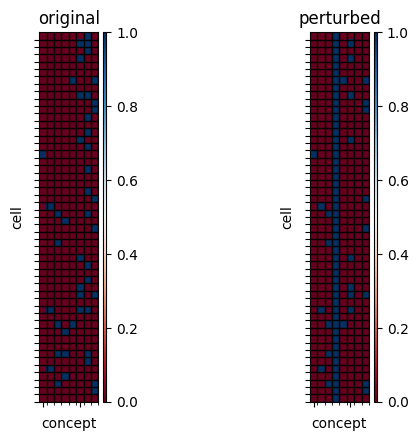

In [101]:
fig,ax = plt.subplots(1,2)
clab.datagen.plot.matrix_plot(dataset.concepts.to_numpy()[0:50,:], xlabel='concept', ylabel = 'cell', ax=ax[0],show =False)
clab.datagen.plot.matrix_plot(new_concepts[0:50,:], xlabel='concept', ylabel = 'cell', ax=ax[1],show = False)
ax[0].set_title('original')
ax[1].set_title('perturbed')
plt.show()

Use the `generate_intervention` method from the Generator class. This takes an old dataset, and the new concepts (all other covariates are kept the same). The result will be the perturbed gene expression for the _same_ cells as in the original data but with the new concepts (remember this is a probabilistic model).

In [102]:
new_data = clab.datagen.omics.OmicsDataGenerator.generate_intervention(dataset, new_concepts)

## Evaluation | Visual

Get the old (original) gene expression data from the dataset object.

In [103]:
old_data = dataset.data.to_dataframe().unstack()['data'].copy()

Grab the concept coefficients - this is a `n_concept x n_gene` matrix which tells you how much each each gene is influenced by the different concepts.
<br><br>
A positive coefficient means that the gene is more highly expressed in the cells with the concept active and a negative coefficient means the opposite. This is agreement with the idea if up-and downregulation of genes.

In [104]:
coefs = dataset.concept_coef.to_dataframe().unstack()['concept_coef']

We can inspect a subset of the coefficient matrix

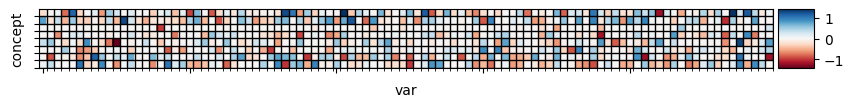

In [105]:
fig,ax = plt.subplots(1,1, figsize = (10,6))
clab.datagen.plot.matrix_plot(coefs.values[:,0:100], ylabel='concept', xlabel = 'var', ax = ax,show = False)

We pick one of the concepts we perturbed and inpect the impact of this one

In [106]:
pert_concept = pert_add_concept[0]

We get the names of the genes with positive and negative coefficient values for the concept we perturbed

In [107]:
pos_concept_vars = coefs.columns[(coefs.iloc[pert_concept,:] > 0).values].tolist()
neg_concept_vars = coefs.columns[(coefs.iloc[pert_concept,:] < 0).values].tolist()

Next, we compute the average gene expression across the pos/neg concept genes in every cell in the original and perturbed data.

In [108]:
results = dict(values = [], data= [], coef_direction = [])
for data_name,data in zip(['perturbed','original'],[new_data,old_data]):
    for direction_name,genes in zip(['up','down'],[pos_concept_vars,neg_concept_vars]):
        ndata = data.loc[:,genes].copy()
        ndata = ndata.mean(axis=1).values
        results['values'] += ndata.tolist()
        results['data'] += len(ndata) * [data_name]
        results['coef_direction'] += len(ndata) * [direction_name]

results = pd.DataFrame(results)
# for visualization
results['data'] = pd.Categorical(results['data'], ['original','perturbed'])

In [109]:
import matplotlib.pyplot as plt

Visualize the results

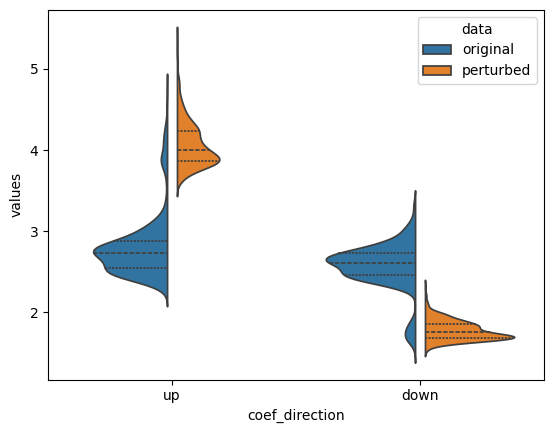

In [110]:
sns.violinplot(results, y = 'values', x = 'coef_direction', hue = 'data', split=True, gap=.1, inner="quart")
plt.show()

The gene expression of the genes with positive coefficients (up) are more highly expressed in the perturbed case while the gene expression is lower for the genes with negative coefficients (down). This is exactly what we expect.

## Evaluation | Quantiative

We can also examine this in a more **quantitative** manner using our evaluation tools

Get the old and new concept indicator values

In [111]:
old_concepts = dataset.concepts.to_dataframe().unstack()['concepts'].copy()
new_concepts = pd.DataFrame(new_concepts, index = old_concepts.index, columns = old_concepts.columns)

Evaluate whether an the intervention was successful. This method automatically detects which concepts that were perturbed and whether they were activated/inactivated. The test then assesses whether the intervention manifested successfully on the three sets of genes: genes that should be up-regulated when the concept is acrive, genes that should be down-regulated, and genes that shouldn't be affected. The evaluation takes the form of a Wilcoxon signed rank test, with the appropriate direction.

In [112]:
eval_res = clab.evaluation.interventions.DistributionShift.score(old_data, new_data, old_concepts, new_concepts, coefs)

Inspect the results

In [113]:
clab.evaluation.interventions.DistributionShift.pretty_display(eval_res)

              0->1 : pos     0->1 : neg  0->1 : neu     1->0 : pos     1->0 : neg  1->0 : neu
concept_3  5.278191e-307  5.277852e-307    0.538341            NaN            NaN         NaN
concept_6            NaN            NaN         NaN  1.705540e-104  1.705555e-104    0.266046


This is the expected result, we want to see statistically significant p-values for the pos/neg (genes with positive and negative regulation) and non-signficant p-values for the neutral genes (not associated with the concept). <br>
<br>
The NaN's are expected because we only do the intervention 0->1 for concept 3 and only 1->0 for concept 6. Had we intervened 0->1 on some cells and 1->0 on other cells in both concepts, these NaNs would not appear.